## Computational Cognitive Science - Assignment #03
*Aleksejs Timcenko, NIP*

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats # these can be useful to compute cdf's
from tqdm import tqdm

### Exercise 3.1

Implement the accuracy maximization, probability matching and sample-based decision-making stratregies for the Kalman filter as discussed in the lecture. Run each model and plot their probability of making a correct choice over trials (averaged over multiple tasks).

In [4]:
# returns:
# inputs: numpy array of shape (num_alien X task_length X features)
# targets: numpy array of shape (num_alien X task_length X 1) 
# A_wins: numpy array of shape (task_length X 1)
def generate_task(num_inputs, length_tasks, sigma_y):
    true_weights = np.random.randn(num_inputs, 1)
    inputs = np.random.randn(2 * length_tasks, num_inputs)
    targets = inputs @ true_weights + sigma_y * np.random.randn(2 * length_tasks, 1)
    inputs = inputs.reshape((2, length_tasks, num_inputs))
    targets = targets.reshape((2, length_tasks, 1))
    A_wins = targets[0] > targets[1]
    
    return inputs, targets, A_wins

In [6]:
# Kalman filter as implemented in the last exercise
class KalmanFilter():
    def __init__(self, num_inputs, sigma_y, sigma_w):
        self.num_inputs = num_inputs
        self.sigma_y = sigma_y
        self.sigma_w = sigma_w
        
        self.weights = np.zeros((num_inputs, 1))
        self.covariance = sigma_w * np.eye(num_inputs)
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        std = np.sqrt(inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        return mean, std
        
    def learn(self, inputs, targets):
        kalman_numerator = self.covariance @ inputs
        kalman_denominator = inputs.T @ self.covariance @ inputs + self.sigma_y ** 2
        kalman_gain = kalman_numerator / kalman_denominator
        
        self.weights = self.weights + kalman_gain * (targets - self.weights.T @ inputs)
        self.covariance = self.covariance - kalman_gain @ inputs.T @ self.covariance

In [34]:
%%time
length_tasks = 10
num_tasks = 10000
num_inputs = 10
sigma_y = 1

K_sb = 10

np.random.seed(42)

# used to store performance for each task and time step
corrects_AM = np.zeros((num_tasks, length_tasks))
corrects_PM = np.zeros((num_tasks, length_tasks))
corrects_SB10 = np.zeros((num_tasks, length_tasks))

for task in tqdm(range(num_tasks)):
    
    # generate the data
    inputs, targets, A_wins = generate_task(num_inputs, length_tasks, sigma_y)
    
    # initialize the model
    model = KalmanFilter(num_inputs, sigma_y, sigma_w=1)
    
    # iterate over each task    
    for trial in range(length_tasks):
        
        # make predictions for observed features
        # AM
        mean_A, std_A = model.predict(inputs[0, [trial], :].T)
        mean_B, std_B = model.predict(inputs[1, [trial], :].T)
        
        # PM
        sample_A = stats.norm(loc=mean_A, scale=std_A).rvs()
        sample_B = stats.norm(loc=mean_B, scale=std_B).rvs()
        p_a_thompson = np.squeeze(stats.norm.cdf((mean_A - mean_B) / np.sqrt(2) / sigma_y))
        
        # SB
        p_a_binomial = 1 - stats.binom(n=K_sb, p=p_a_thompson).cdf(np.floor(K_sb) / 2)

        # Predictions
        pred_AM = int(mean_A > mean_B)     
        pred_PM = int(sample_A > sample_B)  
        pred_SB10 = np.random.choice([0, 1], p=[1 - p_a_binomial, p_a_binomial])

        # store performance measured by number of correct responses
        corrects_AM[task, trial] = pred_AM == A_wins[[trial]]
        corrects_PM[task, trial] = pred_PM == A_wins[[trial]]
        corrects_SB10[task, trial] = pred_SB10 == A_wins[[trial]]

        # update model for observed data
        model.learn(inputs[0, [trial], :].T, targets[0, [trial], :])
        model.learn(inputs[1, [trial], :].T, targets[1, [trial], :])

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:03<00:00, 27.50it/s]

CPU times: total: 5min 48s
Wall time: 6min 3s


In [37]:
np.save("../data/corrects_AM.npy", corrects_AM)
np.save("../data/corrects_PM.npy", corrects_PM)
np.save("../data/corrects_SB10.npy", corrects_SB10)

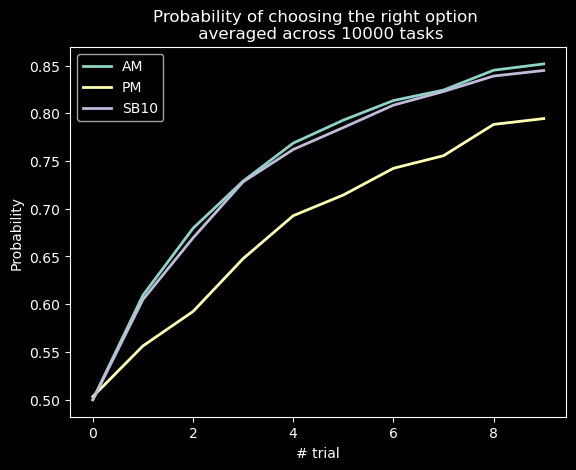

In [41]:
prob_correct_AM = corrects_AM.mean(axis=0)
prob_correct_PM = corrects_PM.mean(axis=0)
prob_correct_SB10 = corrects_SB10.mean(axis=0)

MP_CONTEXT = 'dark_background'

with plt.style.context(MP_CONTEXT):
    plt.plot(prob_correct_AM, linewidth=2, label='AM')
    plt.plot(prob_correct_PM, linewidth=2, label='PM')
    plt.plot(prob_correct_SB10, linewidth=2, label='SB10')
    plt.title(f"Probability of choosing the right option \n averaged across {num_tasks} tasks")
    plt.xlabel("# trial")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

### Exercise 3.2

Let us now assume that making a correct decision incurs in a reward of $100$, but drawing samples is costly. Plot the resulting reward function for the sample-based agent with $K \in \{1, 10\}$ samples over trials (averaged over multiple tasks) for a cost of $0.5$ per drawn sample.

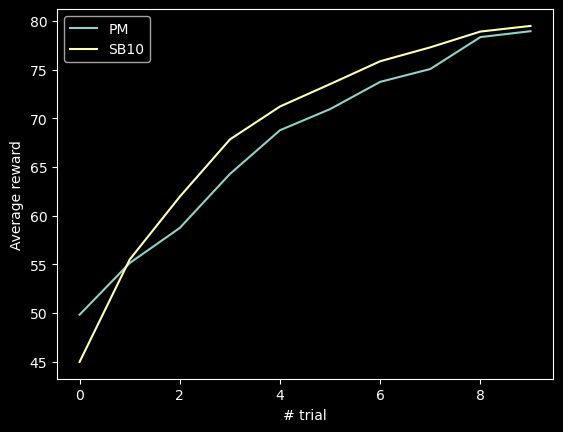

In [51]:
# 0.5 per drawn sample - in each decision SB draws 10 samples - thus -5 is the cost of that decision
# while PM only draws once, which costs -0.5
R = 100

rewards_PM = corrects_PM * R
costs_PM = np.ones(corrects_PM.shape) * 0.5

rewards_SB10 = corrects_SB10 * R
costs_SB10 = np.ones(corrects_SB10.shape) * 5

total_rewards_PM = rewards_PM - costs_PM
total_rewards_SB10 = rewards_SB10 - costs_SB10

with plt.style.context(MP_CONTEXT):
    plt.plot(total_rewards_PM.mean(axis=0), label='PM')
    plt.plot(total_rewards_SB10.mean(axis=0), label='SB10')
    plt.legend()
    plt.xlabel("# trial")
    plt.ylabel("Average reward")
    plt.show()

### Exercise 3.3

Could it make sense to use a sampled-based decision-making rule with an adaptive number of samples (i.e., the number of drawn samples in early trials differs from the number of drawn samples in later trials)? Provide an argument for or against this idea.

*Yes, it does make sense to make the algorithm adaptive. The intuition is that with increasing the # trials the agents learns the distrubutions for A and B better, thus separating them apart. This makes the probability of sample A being larger than sample B higher, implying there is no need for additional draws from the distributions (which is costly). It can be seen from the plot 3.2. that when introducing drawing costs and true positive rewards, the PM outperforms SB10 in the beginning, since even additional drawing does not make a change - the distributions are with identical means. Throughout the trials # 2 - 6 SB10 slightly outperforms PM in expected reward, but at the end of the trial (# 8 - 9) PM shows almost identical performance. This means that in the beginning $K$ can be set low, then it could be set higher and towards the end it should again be set $K \to 1 $*